This notebook conducts and analyzes linear regression for the training set HSE06 bandgaps. It does cross-validation for the three basic types of linear regression (ordinary least squares, ridge regression, and lasso) and completes hyper-parameter tuning for ridge regression and lasso. Each regression type is carried out for five features set: 
- principal components from stoich45 ('Stoich45 PCs')
- features from stoich 45 mutually selected by various methods ('Stoich45 intersection')
- principal components from the 'smoothed' eigenspectra of the sine Coulomb matrices ('SCM PCs')
- 'Stoich45 PCs' and 'SCM PCs' together
- 'Stoich45 intersection' and 'SCM PCs' together

In [992]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score

##### import feature sets:

In [548]:
feature_sets = []
feature_set_labels = []

# import three base feature sets
feature_sets.append(pd.read_csv('../data/datasets_main/Stoich45_PCA_dataset.csv', sep=','))
feature_set_labels.append('Stoich45 PCs')
# ... rename principal component columns to be more descriptive
feature_sets[0] = feature_sets[0].rename(columns = dict([[str(i), 'stoich45 PC '+str(i+1)] for i in range(8)]))

feature_sets.append(pd.read_csv('../data/datasets_main/Stoich45_FeatureSelected_dataset.csv', sep=','))
feature_set_labels.append('Stoich45 intersection')

feature_sets.append(pd.read_csv('../data/datasets_main/SCM_PCA_trainingStoich45_dataset.csv', sep=','))
feature_set_labels.append('SCM PCs')

# merge to form last two
feature_sets.append(feature_sets[0].merge(feature_sets[2]))
feature_set_labels.append('Stoich45 PCs + SCM PCs')

feature_sets.append(feature_sets[1].merge(feature_sets[2]))
feature_set_labels.append('Stoich45 intersection + SCM PCs')

# drop MOF column and rename target in all feature sets
feature_sets = [fs.drop(columns = ['MOF']).rename(columns = {'outputs.hse06.bandgap': 'HSE06 Bandgap'}) for fs in feature_sets]

##### make defintions for cross validation:

In [1225]:
target = 'HSE06 Bandgap'
kfold = KFold(n_splits = 4, shuffle = True, random_state = 1234)

def get_mean_cv_mse(model, df_feature_set):
     return -cross_val_score(
         model,
         X = df_feature_set.drop(columns = [target]), y = df_feature_set[target],
         cv = kfold, scoring = 'neg_mean_squared_error',
         n_jobs = 4
     ).mean()

def get_mean_cv_mse_and_frac_error(model, df_feature_set):
    validation_target_means = [
        df_feature_set[target][test_index].mean()
        for (train_index, test_index) in kfold.split(df_feature_set)
    ]
    mses = -cross_val_score(
        model,
        X = df_feature_set.drop(columns = [target]), y = df_feature_set[target],
        cv = kfold, scoring = 'neg_mean_squared_error',
        n_jobs = 4
    )
    return (mses.mean(), (np.sqrt(mses) / validation_target_means).mean())

#### baseline
What is the mean cross-validation MSE for the above k-fold split using just the constant predictor?

In [965]:
# create a data frame with just the target and a constant feature
df_constant_only = feature_sets[0][[target]].copy()
df_constant_only['constant'] = np.ones_like(feature_sets[0][target])

# run linear regression on the above data set
model = LinearRegression(fit_intercept = False)
cv_mse_no_features = get_mean_cv_mse(model, df_constant_only)
cv_mse_no_features

1.1471062514401023

In [966]:
# test the get_mean_cv_mse_and_frac_error function
get_mean_cv_mse_and_frac_error(model, df_constant_only)

(1.1471062514401023, 0.2782471862228064)

# Linear Regression on All Features in Each Feature Set
Start by 'blindly' regressing over all features in each feature set.

## Ordinary Least Squares (OLS) Linear Regression

#### cross-validation:

In [365]:
ols_cv_mse = np.zeros((len(feature_sets),))
print(f"{'Feature Set':<35}{'Cross-Validation MSE'}")

for (i, fs) in enumerate(feature_sets):
    ols_cv_mse[i] = get_mean_cv_mse(LinearRegression(),fs)
    print(f"{feature_set_labels[i]:<35}{round(ols_cv_mse[i],6)}")

Feature Set                        Cross-Validation MSE
Stoich45 PCs                       0.803314
Stoich45 intersection              0.685575
SCM PCs                            0.862338
Stoich45 PCs + SCM PCs             0.752578
Stoich45 intersection + SCM PCs    0.670345


#### analysis:
Is there any structure in the residuals (for OLS linear regression on the full training set)?

[-0.12265494  0.13336894 -0.0421913   0.06459142 -0.03839793 -0.02536967
 -0.14286959 -0.0206471 ]
[ 1.52209716e-01 -2.49833960e-03 -4.81097172e-03 -2.71152286e+00
 -1.02451805e+00  5.37983778e-03  1.31065889e-03 -6.08386624e-03
 -3.49680526e-03 -1.19780623e-03  1.61877778e-03  2.83519989e-03
  9.04862922e-04 -1.76776822e-03 -1.88146706e-03  6.84522289e-03
  2.98177656e-04 -6.69546407e-05 -3.77583586e-02  3.76499497e-02
  1.81807544e-02 -1.88532437e-03  4.58641833e-03]
[  0.83027105  17.18115202 -21.89612526 -22.37440633   1.26859776
   1.08998447   6.60609356 -16.05740329 -16.93954217  15.47054943
 -14.39065849  -0.5548329  -12.00107958  -0.4363598  -14.30198208
 -24.08870842  32.51010549]


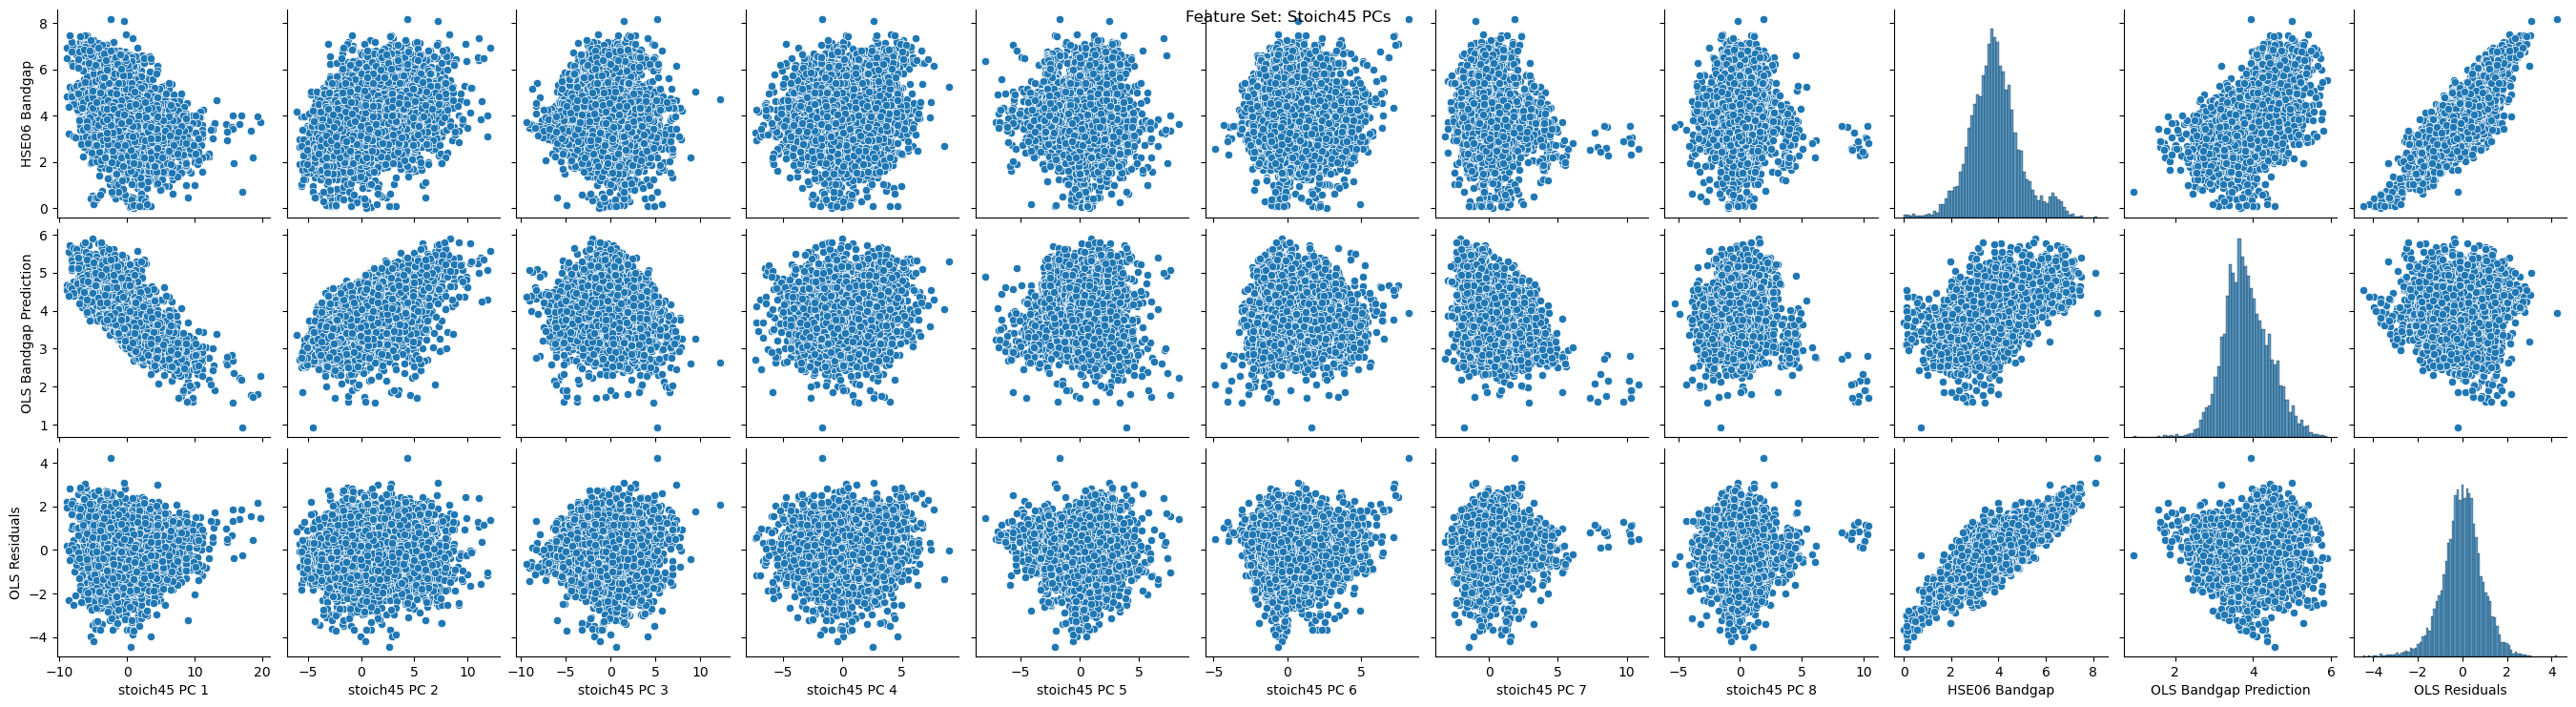

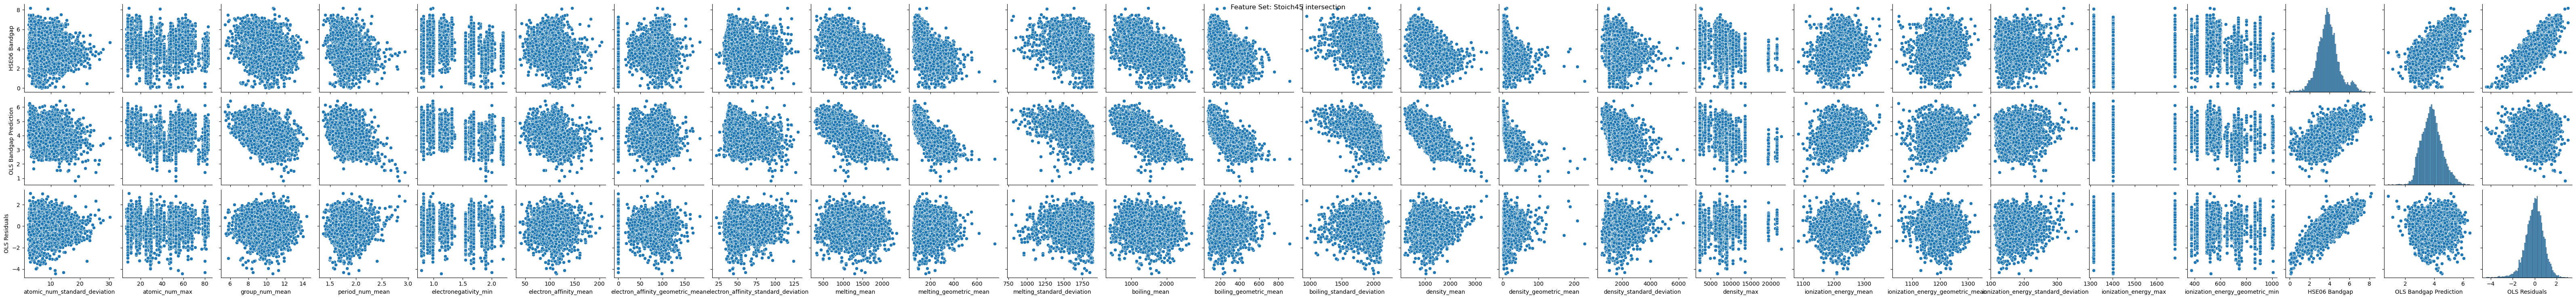

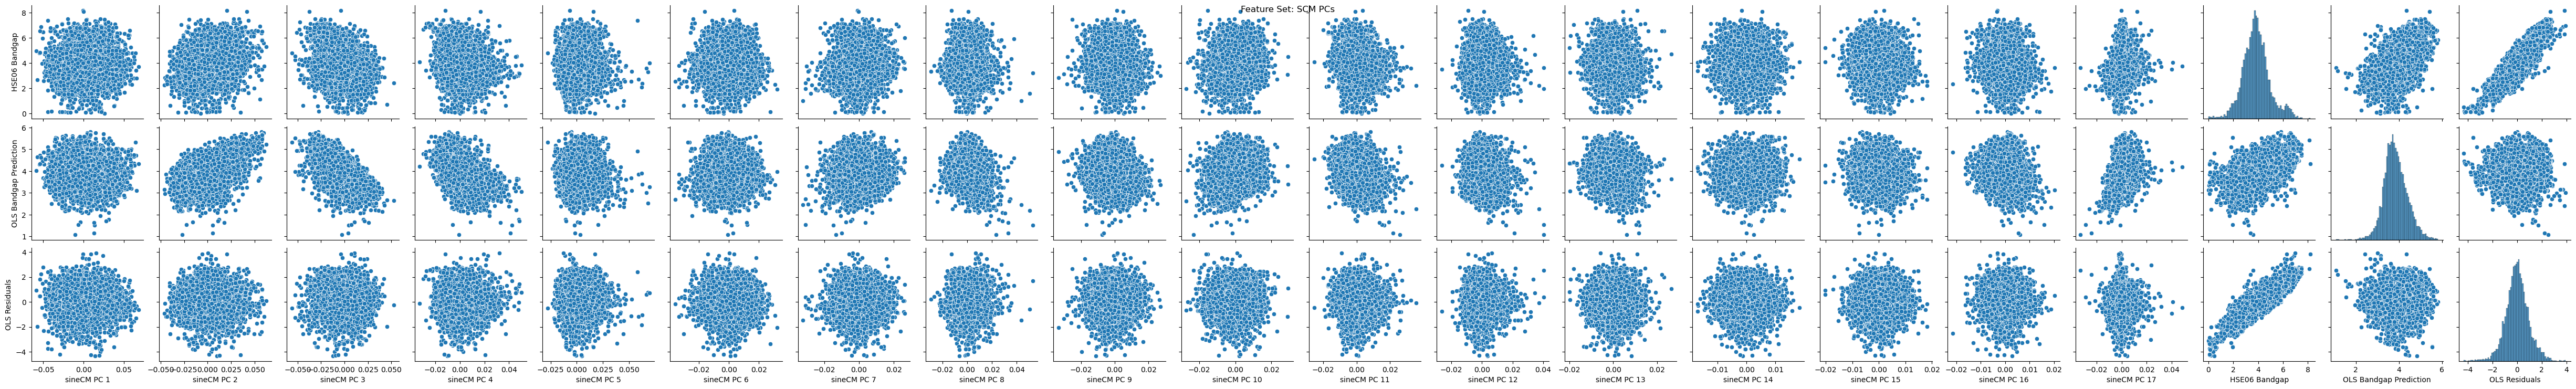

In [845]:
model = LinearRegression()
for i in range(3):
    fs_temp = feature_sets[i].copy()
    model.fit(X = fs_temp.drop(columns = [target]), y = fs_temp[target])
    print(model.coef_)
    fs_temp['OLS Bandgap Prediction'] = model.predict(fs_temp.drop(columns = [target]))
    fs_temp['OLS Residuals'] = fs_temp[target] - fs_temp['OLS Bandgap Prediction']
    g = sns.pairplot(fs_temp, y_vars = [target, 'OLS Bandgap Prediction', 'OLS Residuals'])
    g.fig.suptitle('Feature Set: ' + feature_set_labels[i])

The residuals have a symmetric, normal-looking distribution, but the distributions of the predicted band gaps are missing some of the structure of the target. 

The rough shapes of the scatter plots of the residual against a predictors in most cases match the rough shape of target against the predictors. And the residuals are roughly linear against the target (more so than the predicted values against the target). It is not clear how to extract more predictive power out of these predictors.

## Ridge Regression
... with prescaling

#### hyper-parameter tuning via cross-validation:
Tune the hyper-parameter alpha 'manually' by repeating the regression for a range of alpha values so that a minimum in cross-validation MSE is 'smoothly resolved' graphically. Then pick the alpha from that range that minimizes the MSE.

Feature Set                         Cross-Validation MSE      alpha
Stoich45 PCs                        0.80331                   23.0
Stoich45 intersection               0.685502                  0.61
SCM PCs                             0.862325                  42.0
Stoich45 PCs + SCM PCs              0.752497                  90.0
Stoich45 intersection + SCM PCs     0.670129                  1.32


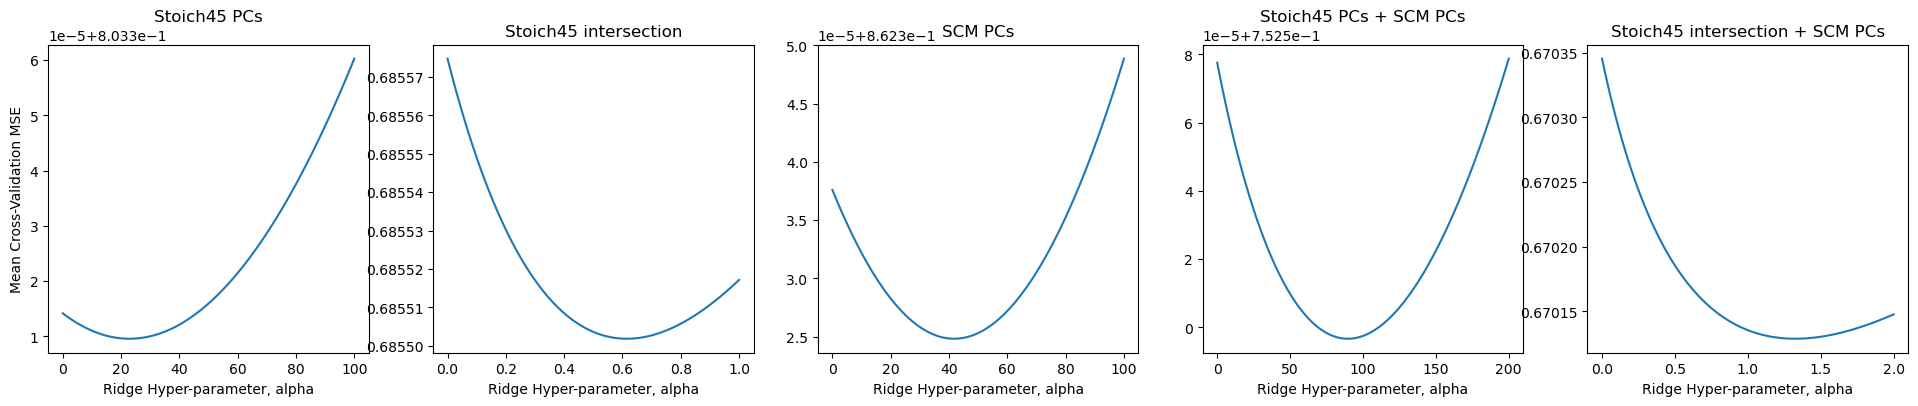

In [846]:
base_alpha_list = np.arange(0.0,1.01,0.01)
ridge_alpha_scale_list = [100.0, 1.0, 100.0, 200.0, 2.0] #set manually to resolve minima

ridge_cv_mse = np.zeros((len(feature_sets), len(base_alpha_list)))
ridge_optimal_alpha = np.zeros((len(feature_sets),))

print(f"{'Feature Set':<35} {'Cross-Validation MSE':<25} {'alpha'}")
fig, axs = plt.subplots(1, 5, figsize=(24, 4))

for (i, fs) in enumerate(feature_sets):
    alpha_list = ridge_alpha_scale_list[i] * base_alpha_list
    for (j, alpha) in enumerate(alpha_list):
        model = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge(alpha=alpha))])
        ridge_cv_mse[i,j] = get_mean_cv_mse(model, fs)
    
    j_min = np.argmin(ridge_cv_mse[i])
    ridge_optimal_alpha[i] = alpha_list[j_min]
    
    print(f"{feature_set_labels[i]:<35} {round(ridge_cv_mse[i,j_min], 6):<25} {round(ridge_optimal_alpha[i],6)}")
    
    axs[i].plot(alpha_list,ridge_cv_mse[i,:])
    axs[i].set_title(feature_set_labels[i])
    axs[i].set_xlabel('Ridge Hyper-parameter, alpha')
    if i == 0:
        axs[i].set_ylabel('Mean Cross-Validation MSE')

#### analysis:
The cross-validation MSEs are not significantly improved relative to OLS. Regularization does not seem to be doing much. Does this imply that these were good choices for features?

In [370]:
print(f"{'Feature Set':<35} {'Improvement in CV MSE over OLS'}")
for (i, fs) in enumerate(feature_sets):
    print(f"{feature_set_labels[i]:<35} {ols_cv_mse[i] - min(ridge_cv_mse[i]):.10f}")

Feature Set                         Improvement in CV MSE over OLS
Stoich45 PCs                        0.0000046053
Stoich45 intersection               0.0000728604
SCM PCs                             0.0000127820
Stoich45 PCs + SCM PCs              0.0000808548
Stoich45 intersection + SCM PCs     0.0002164544


How much do the coefficients change between OLS and Ridge at the optimal value of alpha (over the entire training set)?

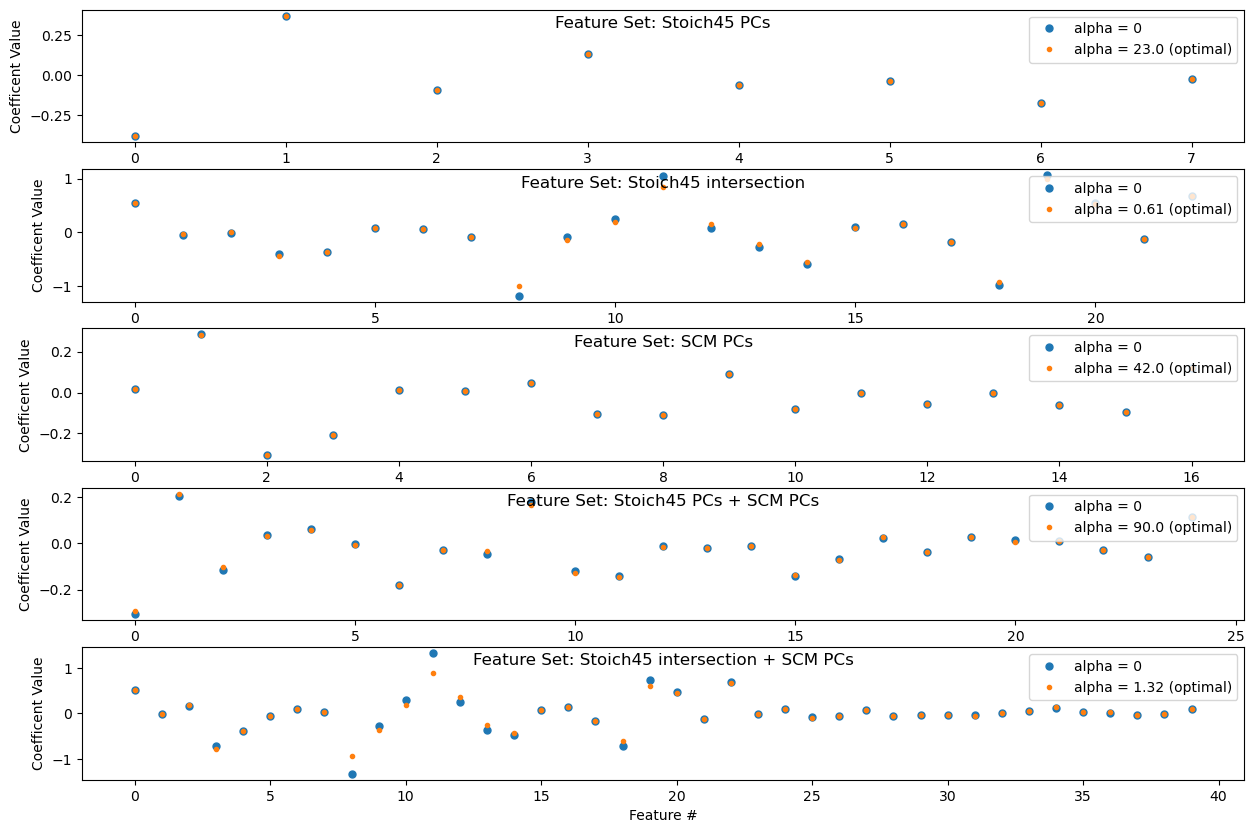

In [893]:
fig, axs = plt.subplots(5,1, figsize=(15, 10))

for i in range(5):
    fs_temp = feature_sets[i].copy()

    # alpha = 0, equivalent to OLS
    model = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge(alpha=0.0))])
    model.fit(X = fs_temp.drop(columns = [target]), y = fs_temp[target])
    axs[i].plot(model['ridge'].coef_, '.', ms = 10.0)

    # alpha optimal
    model = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge(alpha=ridge_optimal_alpha[i]))])
    model.fit(X = fs_temp.drop(columns = [target]), y = fs_temp[target])
    axs[i].plot(model['ridge'].coef_, '.')

    axs[i].legend(['alpha = 0', 'alpha = ' + str(ridge_optimal_alpha[i]) + ' (optimal)'], loc = 'upper right')
    axs[i].set_title('Feature Set: ' + feature_set_labels[i], y = .8)
    axs[i].set_xlabel('Feature #')
    axs[i].set_ylabel('Coefficent Value')

## Lasso
... with pre-scaling.

#### hyper-parameter tuning via cross-validation:
as done for ridge regression above

Feature Set                         Cross-Validation MSE      alpha
Stoich45 PCs                        0.803313                  0.00029
Stoich45 intersection               0.685542                  2.6e-05
SCM PCs                             0.862216                  0.0033
Stoich45 PCs + SCM PCs              0.752563                  0.00047
Stoich45 intersection + SCM PCs     0.670329                  4.4e-05


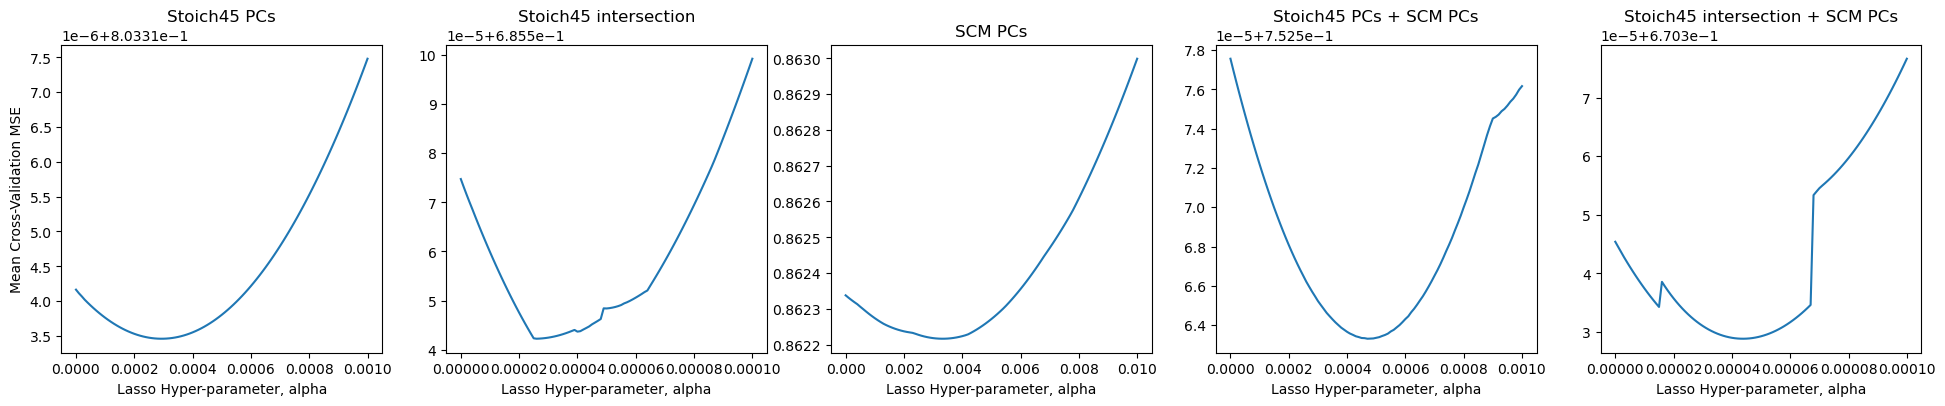

In [894]:
base_alpha_list = np.arange(0.0,1.01,0.01)
lasso_alpha_scale_list = [0.001, 0.0001, 0.01, 0.001, 0.0001] #set manually to resolve minima

lasso_cv_mse = np.zeros((5, len(base_alpha_list)))
lasso_optimal_alpha = np.zeros((len(feature_sets),))

print(f"{'Feature Set':<35} {'Cross-Validation MSE':<25} {'alpha'}")
fig, axs = plt.subplots(1, 5, figsize=(24, 4))

for (i, fs) in enumerate(feature_sets):
    alpha_list = lasso_alpha_scale_list[i] * base_alpha_list
    for (j, alpha) in enumerate(alpha_list):
        if alpha == 0.0:
            model = LinearRegression()
        else:
            model = Pipeline([('scaler', StandardScaler()), ('lasso', Lasso(alpha=alpha, max_iter=100000))])
        lasso_cv_mse[i,j] = get_mean_cv_mse(model, fs)
    
    j_min = np.argmin(lasso_cv_mse[i])
    lasso_optimal_alpha[i] = alpha_list[j_min]
    
    print(f"{feature_set_labels[i]:<35} {round(lasso_cv_mse[i,j_min], 6):<25} {round(lasso_optimal_alpha[i],6)}")
    
    axs[i].plot(alpha_list,lasso_cv_mse[i,:])
    axs[i].set_title(feature_set_labels[i])
    axs[i].set_xlabel('Lasso Hyper-parameter, alpha')
    if i == 0:
        axs[i].set_ylabel('Mean Cross-Validation MSE')

#### analysis:
Across all feature sets, alpha had to be very small to resolve any minimum. But then the above curves in some cases are somewhat jagged. Is there a way to improve this? Does it matter? As with ridge regression, cross-validation MSE are not significantly improved relative to OLS.

In [372]:
print(f"{'Feature Set':<35} {'Improvement in CV MSE over OLS'}")
for (i, fs) in enumerate(feature_sets):
    print(f"{feature_set_labels[i]:<35} {ols_cv_mse[i] - min(lasso_cv_mse[i]):.10f}")

Feature Set                         Improvement in CV MSE over OLS
Stoich45 PCs                        0.0000007047
Stoich45 intersection               0.0000324843
SCM PCs                             0.0001212806
Stoich45 PCs + SCM PCs              0.0000142458
Stoich45 intersection + SCM PCs     0.0000165483


How much do the coefficients change between OLS and Lasso?

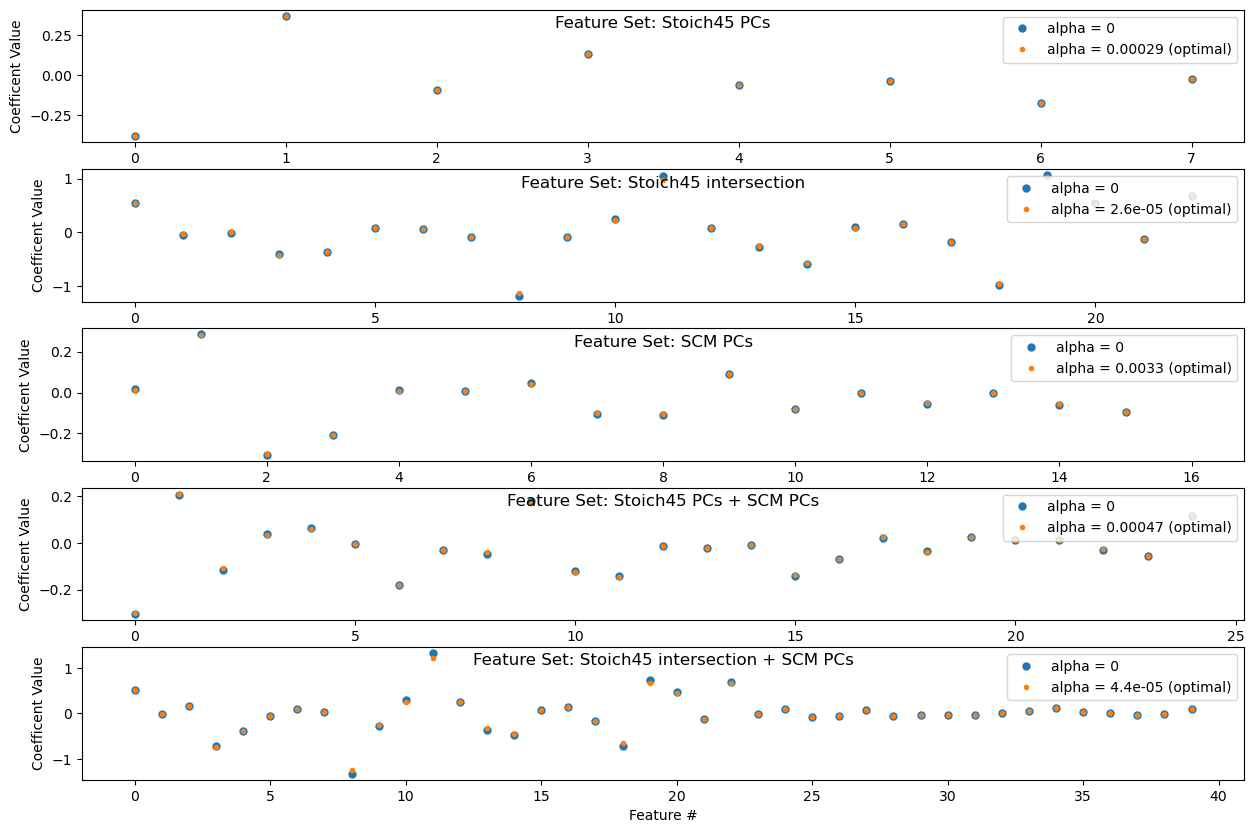

In [896]:
fig, axs = plt.subplots(5,1, figsize=(15, 10))

for i in range(5):
    fs_temp = feature_sets[i].copy()

    # alpha = 0
    model = Pipeline([('scaler', StandardScaler()), ('reg', LinearRegression())])
    model.fit(X = fs_temp.drop(columns = [target]), y = fs_temp[target])
    axs[i].plot(model['reg'].coef_, '.', ms = 10.0)

    # alpha optimal
    model = Pipeline([('scaler', StandardScaler()), ('lasso', Lasso(alpha=lasso_optimal_alpha[i], max_iter=100000))])
    model.fit(X = fs_temp.drop(columns = [target]), y = fs_temp[target])
    axs[i].plot(model['lasso'].coef_, '.')

    axs[i].legend(['alpha = 0', 'alpha = ' + str(round(lasso_optimal_alpha[i],6)) + ' (optimal)'], loc = 'upper right')
    axs[i].set_title('Feature Set: ' + feature_set_labels[i], y = .8)
    axs[i].set_xlabel('Feature #')
    axs[i].set_ylabel('Coefficent Value')

Are any features completely 'zeroed out' by the L1 penalty?

In [373]:
print(f"{'Feature Set':<35} {'Dropped Features'}")

for (i, fs) in enumerate(feature_sets):

    # train with the full training set using the above determined alpha values
    model = Pipeline([('scaler', StandardScaler()), ('lasso', Lasso(alpha=lasso_optimal_alpha[i], max_iter=100000))])
    model.fit(fs.drop(columns = [target]), fs[target])

    # print features that have a coefficient of 0.0
    dropped_features = fs.drop(columns = [target]).columns[model['lasso'].coef_ == 0.0].to_list()
    print(f"{feature_set_labels[i]:<35} {dropped_features}")

Feature Set                         Dropped Features
Stoich45 PCs                        []
Stoich45 intersection               []
SCM PCs                             ['sineCM PC 12', 'sineCM PC 14']
Stoich45 PCs + SCM PCs              []
Stoich45 intersection + SCM PCs     []


Yes, for the SCM PCs dataset. But the coefficients of those features were already the closest to 0 within that dataset:

In [906]:
model = Pipeline([('scaler', StandardScaler()), ('reg', LinearRegression())])
model.fit(X = feature_sets[2].drop(columns = [target]), y = feature_sets[2][target])

print(f"{'Feature':<15} {'Coefficient (OLS)'}")
for (feature, coef) in zip(feature_sets[2].drop(columns = [target]).columns, model['reg'].coef_):
    print(f"{feature:<15} {coef}")


Feature         Coefficient (OLS)
sineCM PC 1     0.016576548313838278
sineCM PC 2     0.28427881050101156
sineCM PC 3     -0.30561903175411675
sineCM PC 4     -0.2084733449187041
sineCM PC 5     0.011275909795847772
sineCM PC 6     0.00885713744736558
sineCM PC 7     0.045046938379914386
sineCM PC 8     -0.1044299014126245
sineCM PC 9     -0.10851705779922467
sineCM PC 10    0.09278277845862871
sineCM PC 11    -0.0824665498659902
sineCM PC 12    -0.0030945963527098243
sineCM PC 13    -0.05629488242380893
sineCM PC 14    -0.0019144778664119226
sineCM PC 15    -0.06076483908822573
sineCM PC 16    -0.09695596200523758
sineCM PC 17    0.12220004037302859


## misc. tests / experiments
#### Is multi-fold cross-validation needed?
What is the distribution of validation MSEs for many different single train-test splits? How does that compare to the distribution of mean CV MSEs for many different 4-fold splits?

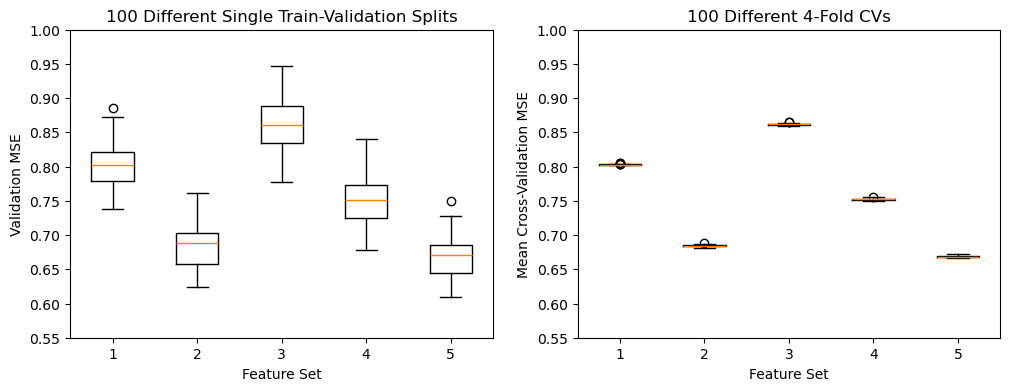

In [812]:
model = LinearRegression()

# this produces 100 different 'regular' train-test splits
from sklearn.model_selection import ShuffleSplit
split = ShuffleSplit(n_splits=100, train_size = 0.8, random_state=0)

cv_mses_1split = [
    -cross_val_score(
             model,
             X = fs.drop(columns = [target]), y = fs[target],
             cv = split, scoring = 'neg_mean_squared_error',
             n_jobs = 4
         )
    for fs in feature_sets
]

# 100 different 4-fold cross-validations
cv_mses_4fold = np.zeros((5,100))
for (i, fs) in enumerate(feature_sets):
    for (j, rs) in enumerate(range(1234,1334)):
        kfold_temp = KFold(n_splits = 4, shuffle = True, random_state = rs)
        cv_mses_4fold[i,j] = -cross_val_score(
             model,
             X = fs.drop(columns = [target]), y = fs[target],
             cv = kfold_temp, scoring = 'neg_mean_squared_error',
             n_jobs = 4
         ).mean()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].boxplot(cv_mses_1split)
axs[0].set_ylim((.55,1.0))
axs[0].set_xlabel('Feature Set')
axs[0].set_ylabel('Validation MSE')
axs[0].set_title('100 Different Single Train-Validation Splits')

axs[1].boxplot(cv_mses_4fold.T)
axs[1].set_ylim((.55,1.0))
axs[1].set_xlabel('Feature Set')
axs[1].set_ylabel('Mean Cross-Validation MSE')
axs[1].set_title('100 Different 4-Fold CVs')

plt.show()

The distributions are tighter using 4-fold cross-validation, as would be expected from the central limit theorem. The question is: Is the variablity in the single-split MSEs acceptable? Could a 'bad' seed choice lead to the wrong conclusions about models and feature sets?

#### PCA with whitening before Ridge regression:
Does running PCA with whitening before Ridge regression affect the results? Motivation: ridge regression penalizes the coefficient for each column in the design matrix equally. We normally stanardize the columns, so that the variance in each column is treated equally. But what if we want the variance to affect the principal components equally instead?
Notes:
- introducing PCA _without_ whitening amounts to an orthogonal transformation of the design matrix and coefficients. It should not affect the value of the L2 penalty term, and so should yield the same results as doing no PCA at all. (This is shown by the overlap of the blue and orange curves below.)
- 'whiten' is an option in PCA, which is why I refer to it above. But it should be equivalent to running a second standard scaler after PCA. (This is shown by the overlap of the green and red curves below.)

This test is done with the 'Stoich 45 intersection' feature set. It is the only one without any feature that already came from PCA.

feature set - Stoich45 intersection:


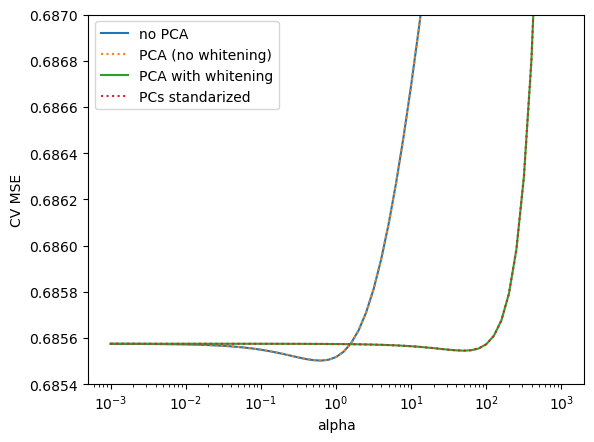

In [750]:
fs_ind = 1
fs = feature_sets[fs_ind]
print('feature set - ' + feature_set_labels[fs_ind] +  ':')

alpha_list = 10 ** np.arange(-3,3.1,.1)
cv_mse_temp = np.zeros((len(alpha_list), 5))

for (i, alpha) in enumerate(alpha_list):
    modelWithoutPCA = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge(alpha=alpha))])
    modelWithPCA = Pipeline([('scaler', StandardScaler()), ('pca', PCA()), ('ridge', Ridge(alpha=alpha))])
    modelWithPCAWhitening = Pipeline([('scaler', StandardScaler()), ('pca', PCA(whiten=True)), ('ridge', Ridge(alpha=alpha))])
    modelWithPCAStandarized = Pipeline([('scaler1', StandardScaler()), ('pca', PCA()), ('scaler2', StandardScaler()), ('ridge', Ridge(alpha=alpha))])
    
    cv_mse_temp[i] = [
        alpha,
        get_mean_cv_mse(modelWithoutPCA, fs),
        get_mean_cv_mse(modelWithPCA, fs),
        get_mean_cv_mse(modelWithPCAWhitening, fs),
        get_mean_cv_mse(modelWithPCAStandarized, fs)
    ]

plt.plot(cv_mse_temp[:,0], cv_mse_temp[:,1])
plt.plot(cv_mse_temp[:,0], cv_mse_temp[:,2],':')
plt.plot(cv_mse_temp[:,0], cv_mse_temp[:,3])
plt.plot(cv_mse_temp[:,0], cv_mse_temp[:,4],':')
plt.legend(['no PCA', 'PCA (no whitening)', 'PCA with whitening', 'PCs standarized'])
plt.xscale('log')
plt.ylim((.6854,.687))
plt.xlabel('alpha')
plt.ylabel('CV MSE')
plt.show()

There is an effect on the cross-validation performance, but it does not show an improvement in the minimum CV MSE. PCA with whitening does not seem useful.

Note: even though the curves with and without whitening are plotted on the same alpha axis above, the CV MSEs at each alpha value should not be compared directly. The variance in each feature is normalized by the whitening, so the degree of L2 penalty associated with a specfic alpha value is not the same with and without whitening. Below is the same plot but with the curves associated with whitening shifted so that the minima roughly line up, and therefore they might be more comparable. The conclusion is the same: whitening does not improve performance.

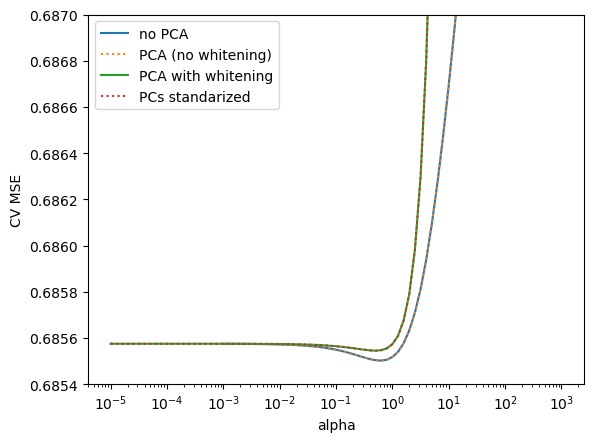

In [753]:
plt.plot(cv_mse_temp[:,0], cv_mse_temp[:,1])
plt.plot(cv_mse_temp[:,0], cv_mse_temp[:,2],':')
plt.plot(cv_mse_temp[:,0]/100, cv_mse_temp[:,3])
plt.plot(cv_mse_temp[:,0]/100, cv_mse_temp[:,4],':')
plt.legend(['no PCA', 'PCA (no whitening)', 'PCA with whitening', 'PCs standarized'])
plt.xscale('log')
plt.ylim((.6854,.687))
plt.xlabel('alpha')
plt.ylabel('CV MSE')
plt.show()

# Linear Regression on Subsets of Features in Each Feature Set

### first feature set: 'Stoich45 PCs'
#### Exhaustive tests with OLS
There are few enough features in the first feature set to try OLS over all $2^8 - 1 = 255$ subsets.

In [399]:
# function borrowed from lecture, in turn from an Erdos alum
def powerset(s):
    power_set = [[]]
    for x in s:
        power_set += [s0+[x] for s0 in power_set]
    return power_set[1:]
    
cols_stoich45_PCs_powerset = powerset(feature_sets[0].columns[:-1])
print('number of subsets:', len(cols_stoich45_PCs_powerset))

number of subsets: 255


In [398]:
ols_stoich45_PCs_subsets_cv_mse = np.zeros((len(cols_stoich45_PCs_powerset),))

for (i, col_subset) in enumerate(cols_stoich45_PCs_powerset):
    df_subset = feature_sets[0][col_subset + [target]]
    ols_stoich45_PCs_subsets_cv_mse[i] = get_mean_cv_mse(LinearRegression(),df_subset)

print('The best performing subset is', cols_stoich45_PCs_powerset[np.argmin(ols_stoich45_PCs_subsets_cv_mse)])

The best performing subset is ['stoich45 PC 1', 'stoich45 PC 2', 'stoich45 PC 3', 'stoich45 PC 4', 'stoich45 PC 5', 'stoich45 PC 6', 'stoich45 PC 7', 'stoich45 PC 8']


The best performing subset is ... just the full set of 8 principal components. That being said, many other subsets come very close in cross-validation error:

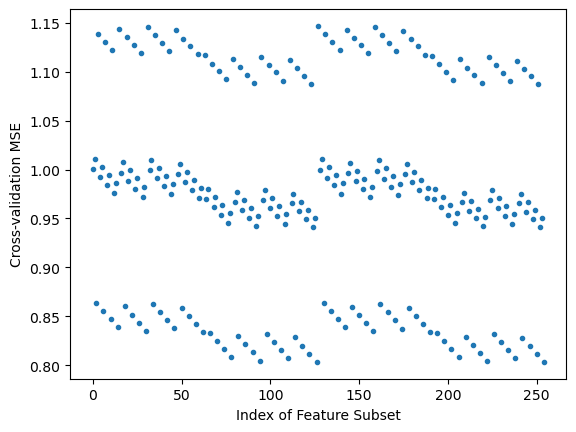

In [403]:
plt.plot(ols_stoich45_PCs_subsets_cv_mse,'.')
plt.xlabel('Index of Feature Subset')
plt.ylabel('Cross-validation MSE')
plt.show()

Which principal components are important? The following plot more clearly shows the members of subsets that yield each cross-validation MSE: a dot appears at $(x,y)$ if prinicpal component $x$ in included in a subset that produces MSE $y$.

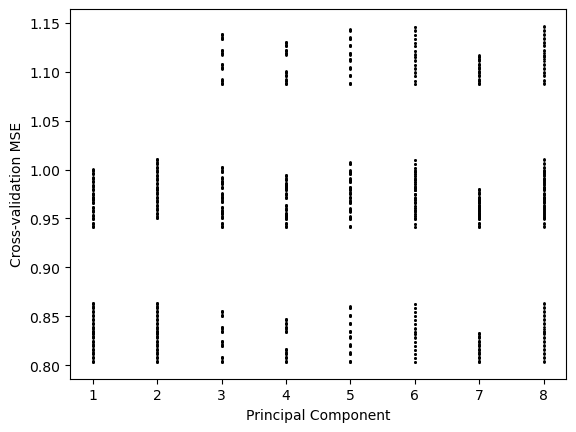

In [500]:
range8_powerset = powerset(np.arange(8) + 1)
fig = plt.figure()
for (index_subset, mse) in zip(range8_powerset, ols_stoich45_PCs_subsets_cv_mse):
    plt.plot(index_subset, mse*np.ones_like(index_subset), 'k.', ms=2)
plt.xlabel('Principal Component')
plt.ylabel('Cross-validation MSE')
plt.show()

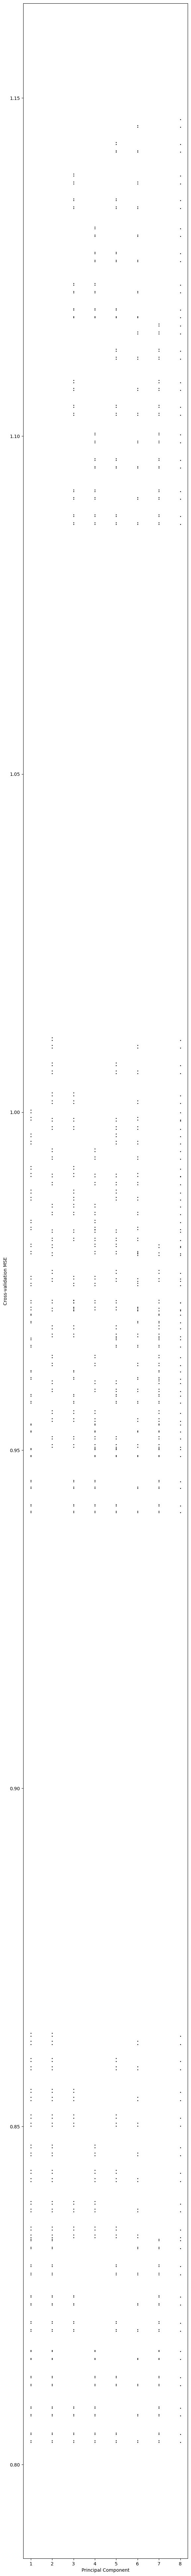

In [501]:
# stretch plot vertically to show dot more clearly
fig.set_figheight(100)
fig

It looks like, at least amongst the best performing subsets, the 8th prinicipal component offers the least predictive power (including it or not changes the cross-validation MSE by the least amount), then the 6th, the 5th and the 3rd.

Note the structure of the above plot: including or excluding any given component seems to make a similar change in the CV MSE no matter what other features are in the subset. To demonstrate, here I repeat two sets of regressions:
 - one over each component by itself and consider the improvement in the CS MSE over constant predictor
 - another over all components but one and consider the decrease in the CS MSE as compared with using all the features

In [910]:
df_results = pd.DataFrame(columns=[
    'Feature',
    'Reduction in CV MSE: single feature vs. just using the constant predictor',
    'Increase in CV MSE: dropping one feature vs. using all 8 components'
])
for i in range(8):
    feature = 'stoich45 PC ' + str(i+1)
    df_single = feature_sets[0][[feature, target]]
    df_all_but_one = feature_sets[0].drop(columns=[feature])
    df_results.loc[i] = [
        feature,
        cv_mse_no_features - get_mean_cv_mse(LinearRegression(),df_single),
        get_mean_cv_mse(LinearRegression(),df_all_but_one) - ols_cv_mse[0]
    ]
df_results.sort_values(df_results.columns[2])

Feature  \
7  stoich45 PC 8   
5  stoich45 PC 6   
4  stoich45 PC 5   
2  stoich45 PC 3   
3  stoich45 PC 4   
6  stoich45 PC 7   
1  stoich45 PC 2   
0  stoich45 PC 1   

   Reduction in CV MSE: single feature vs. just using the constant predictor  \
7                                           0.000291                           
5                                           0.001183                           
4                                           0.003712                           
2                                           0.008347                           
3                                           0.016226                           
6                                           0.030516                           
1                                           0.136062                           
0                                           0.146776                           

   Increase in CV MSE: dropping one feature vs. using all 8 components  
7                                           0.000236                    
5                                           0.001153                    
4                                           0.003912                    
2                                           0.008358                    
3                                           0.016410                    
6                                           0.030244                    
1                                           0.137478                    
0                                           0.147156

The changes in the CV MSE due to each component are very similar, whether starting with no features or all the features.

This (along with the fact that the full set still gives the best CV MSE) could have been anticipated. Since the principal components are mutually orthogonal with respect to the datapoints in the (full) training set, each principal component contributes independently in explaining the variance in the target over that training set. The fact that the components still contribute independently to reduce the _cross-validation_ error means that the joint distribution of the 8 principal components and the target is well-matched between the full training set and the k-fold splits. 

#### Drop features and follow up with regularization
Try ridge regression on the 'Stoich45 PCs' feature sets again, but with between one and four of the least important principal components dropped.

In [586]:
stoich45_sets_with_drops = [
    feature_sets[0].drop(columns = ['stoich45 PC 8']),
    feature_sets[0].drop(columns = ['stoich45 PC 8', 'stoich45 PC 6']),
    feature_sets[0].drop(columns = ['stoich45 PC 8', 'stoich45 PC 6', 'stoich45 PC 5']),
    feature_sets[0].drop(columns = ['stoich45 PC 8', 'stoich45 PC 6', 'stoich45 PC 5', 'stoich45 PC 3'])
]
stoich45_sets_with_drops_labels = [
    'Stoich45 PCs 1234567_',
    'Stoich45 PCs 12345_7_',
    'Stoich45 PCs 1234__7_',
    'Stoich45 PCs 12_4__7_'
]

Feature Set                         Cross-Validation MSE      alpha
Stoich45 PCs 1234567_               0.803548                  14.6
Stoich45 PCs 12345_7_               0.804692                  9.0
Stoich45 PCs 1234__7_               0.808527                  10.0
Stoich45 PCs 12_4__7_               0.816891                  11.6


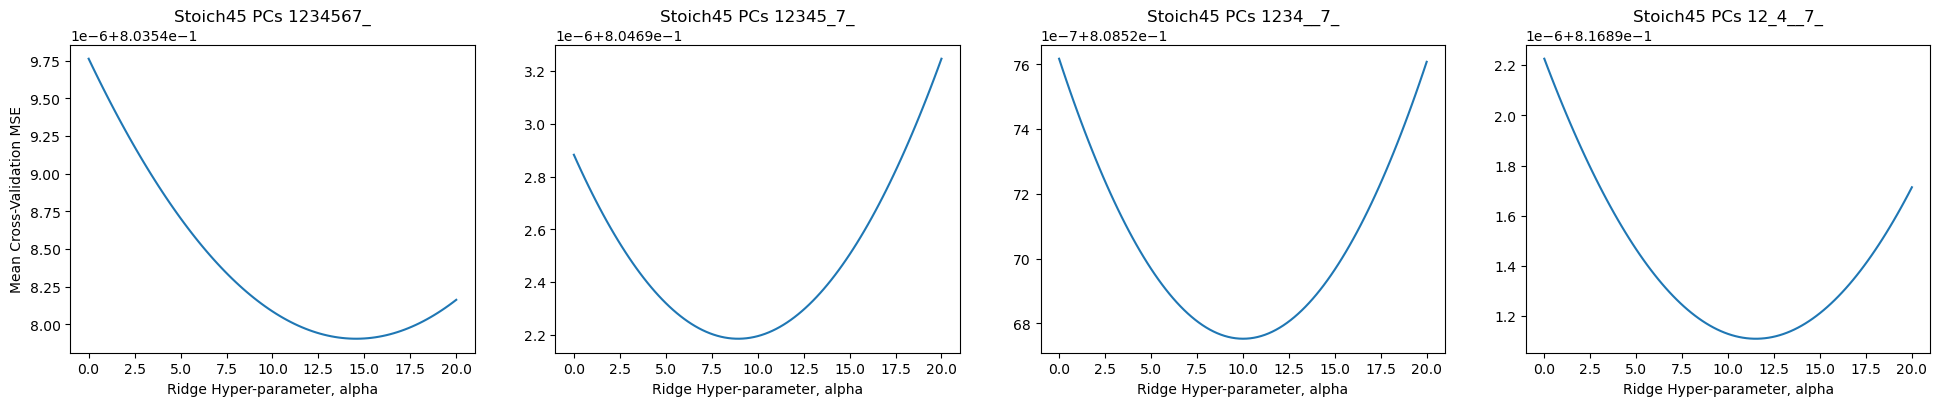

In [587]:
base_alpha_list = np.arange(0.0,1.01,0.01)
ridge_alpha_scale_list = [20.0, 20.0, 20.0, 20.0] #set manually to resolve minima

print(f"{'Feature Set':<35} {'Cross-Validation MSE':<25} {'alpha'}")
fig, axs = plt.subplots(1, len(stoich45_sets_with_drops), figsize=(24, 4))

for (i, fs) in enumerate(stoich45_sets_with_drops):
    alpha_list = ridge_alpha_scale_list[i] * base_alpha_list
    cv_mse_temp_list = []
    for (j, alpha) in enumerate(alpha_list):
        model = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge(alpha=alpha))])
        cv_mse_temp_list.append(get_mean_cv_mse(model, fs))
    
    j_min = np.argmin(cv_mse_temp_list)
    print(f"{stoich45_sets_with_drops_labels[i]:<35} {round(cv_mse_temp_list[j_min], 6):<25} {round(alpha_list[j_min],6)}")
    
    axs[i].plot(alpha_list,cv_mse_temp_list)
    axs[i].set_title(stoich45_sets_with_drops_labels[i])
    axs[i].set_xlabel('Ridge Hyper-parameter, alpha')
    if i == 0:
        axs[i].set_ylabel('Mean Cross-Validation MSE')

There is no improvement beyond using all features in this set.

### third feature set: 'SCM PCs'
Repeat the above analysis for the principal components from the sine Coulomb matrix: find individual component importance via cross-validation, drop the least important, and repeat regression.

In [911]:
df_results = pd.DataFrame(columns=[
    'Feature',
    'Reduction in CV MSE: single feature vs. just using the constant predictor',
    'Increase in CV MSE: dropping one feature vs. using all 17 components'
])
for i in range(17):
    feature = 'sineCM PC ' + str(i+1)
    df_single = feature_sets[2][[feature, target]]
    df_all_but_one = feature_sets[2].drop(columns=[feature])
    df_results.loc[i] = [
        feature,
        cv_mse_no_features - get_mean_cv_mse(LinearRegression(),df_single),
        get_mean_cv_mse(LinearRegression(),df_all_but_one) - ols_cv_mse[2]
    ]
df_results.sort_values(df_results.columns[2])

Feature  \
13  sineCM PC 14   
11  sineCM PC 12   
4    sineCM PC 5   
5    sineCM PC 6   
0    sineCM PC 1   
6    sineCM PC 7   
12  sineCM PC 13   
14  sineCM PC 15   
10  sineCM PC 11   
15  sineCM PC 16   
9   sineCM PC 10   
7    sineCM PC 8   
8    sineCM PC 9   
16  sineCM PC 17   
3    sineCM PC 4   
1    sineCM PC 2   
2    sineCM PC 3   

    Reduction in CV MSE: single feature vs. just using the constant predictor  \
13                                          -0.000510                           
11                                          -0.000137                           
4                                           -0.001019                           
5                                           -0.000460                           
0                                            0.000150                           
6                                            0.001502                           
12                                           0.002485                           
14                                           0.003223                           
10                                           0.006609                           
15                                           0.008192                           
9                                            0.008406                           
7                                            0.010351                           
8                                            0.011522                           
16                                           0.014195                           
3                                            0.043299                           
1                                            0.080294                           
2                                            0.093436                           

    Increase in CV MSE: dropping one feature vs. using all 17 components  
13                                          -0.000339                     
11                                          -0.000299                     
4                                           -0.000294                     
5                                           -0.000116                     
0                                           -0.000012                     
6                                            0.001644                     
12                                           0.002927                     
14                                           0.003363                     
10                                           0.007024                     
15                                           0.008333                     
9                                            0.008624                     
7                                            0.010679                     
8                                            0.011862                     
16                                           0.014330                     
3                                            0.043959                     
1                                            0.081915                     
2                                            0.094146

The situation here is not as simple as with the stoich45 principal components. There are several features where dropping them individually (slightly) improves CV performance. What is the improvement in the CV MSE if one drops them all?

In [922]:
df_scm_PCs_temp = feature_sets[2].drop(columns=['sineCM PC '+ str(j) for j in [14, 12, 5, 6, 1]])
get_mean_cv_mse(LinearRegression(),df_scm_PCs_temp) - ols_cv_mse[2]

-0.0010362410654772836

Barely any.

# Linear Regression with Polynomial Features
## ... for the Stoich45 Intersection dataset

In [981]:
print("In the following, we will use the " + feature_set_labels[1] + " feature set.")
df_stoich45Int = feature_sets[1]
print("As computed above, the 4-fold CV MSE was " + str(ols_cv_mse[1]) +  " for OLS linear regression over the raw features in this set.")
print("Can this be improved by introducing polynomial features?")

In the following, we will use the Stoich45 intersection feature set.
As computed above, the 4-fold CV MSE was 0.6855747336084684 for OLS linear regression over the raw features in this set.
Can this be improved by introducing polynomial features?


#### helper function
Since adding polynomial features will make linear regression prone to overfitting, define functions to run Ridge and Lasso regressions and help tune their hyperparameters:

In [1042]:
def run_and_tune_Ridge(df, pre_ridge_pipeline = [], alpha_max = 1.0, alpha_divs = 100):
    
    base_alpha_list = np.arange(0.0, 1.0 + 1./alpha_divs, 1./alpha_divs)
    alpha_list = alpha_max * base_alpha_list

    cv_mses = np.zeros_like(alpha_list)
    for (j, alpha) in enumerate(alpha_list):
        model = Pipeline(pre_ridge_pipeline + [('scaler', StandardScaler()), ('ridge', Ridge(alpha=alpha))])
        cv_mses[j]  = get_mean_cv_mse(model, df)
    
    plt.plot(alpha_list,cv_mses)
    plt.xlabel('Ridge Hyper-parameter, alpha')
    plt.ylabel('Average Cross-Validation MSE')
    plt.show()

    j_optimal = np.argmin(cv_mses)
    cv_mse_optimal = cv_mses[j_optimal]
    alpha_optimal = alpha_list[j_optimal]

    print(f"{'OLS CV MSE:':>25} {cv_mses[0]}")
    print(f"{'Ridge optimal CV MSE:':>25} {cv_mse_optimal}")
    print(f"{'optimal alpha:':>25} {alpha_optimal}")
    
    return (cv_mse_optimal, alpha_optimal, cv_mses, alpha_list)

def run_and_tune_Lasso(df, pre_lasso_pipeline = [], alpha_max = 1.0, alpha_divs = 100):
    
    base_alpha_list = np.arange(0.0, 1.0 + 1./alpha_divs, 1./alpha_divs)
    alpha_list = alpha_max * base_alpha_list

    cv_mses = np.zeros_like(alpha_list)
    for (j, alpha) in enumerate(alpha_list):
        if j == 0:
            model = Pipeline(pre_lasso_pipeline + [('scaler', StandardScaler()), ('reg', LinearRegression())])
        else:
            model = Pipeline(pre_lasso_pipeline + [('scaler', StandardScaler()), ('lasso', Lasso(alpha=alpha, max_iter=100000))])
        cv_mses[j]  = get_mean_cv_mse(model, df)
    
    plt.plot(alpha_list,cv_mses)
    plt.xlabel('Lasso Hyper-parameter, alpha')
    plt.ylabel('Average Cross-Validation MSE')
    plt.show()

    j_optimal = np.argmin(cv_mses)
    cv_mse_optimal = cv_mses[j_optimal]
    alpha_optimal = alpha_list[j_optimal]

    print(f"{'OLS CV MSE:':>25} {cv_mses[0]}")
    print(f"{'Lasso optimal CV MSE:':>25} {cv_mse_optimal}")
    print(f"{'optimal alpha:':>25} {alpha_optimal}")
    
    return (cv_mse_optimal, alpha_optimal, cv_mses, alpha_list)

### adding quadratic features and re-running OLS and Ridge Regression
#### including the squares of all the raw features (without interaction terms)
This needs to be done 'manually' as PolynomialFeatures from sklearn will either produce all quadratic terms or just the interaction terms.

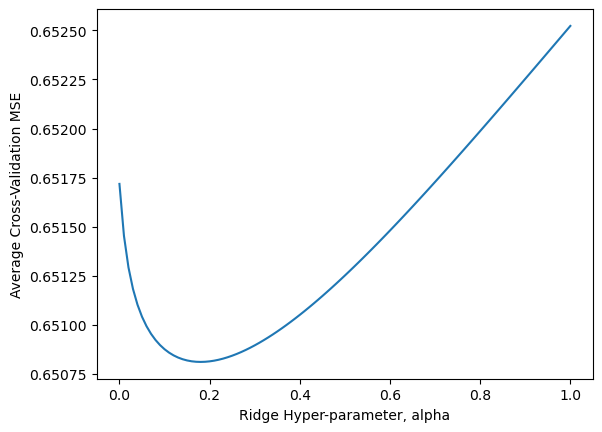

              OLS CV MSE: 0.6517180629085333
    Ridge optimal CV MSE: 0.6508112663934355
           optimal alpha: 0.18


In [1039]:
df_stoich45Int_withSquares = df_stoich45Int.copy()
for col in df_stoich45Int.columns[:-1]:
    df_stoich45Int_withSquares[col + ' ^ 2'] = df_stoich45Int[col] **2

run_and_tune_Ridge(df_stoich45Int_withSquares);

#### including just the quadratic interaction terms (a new term for each pair of features)

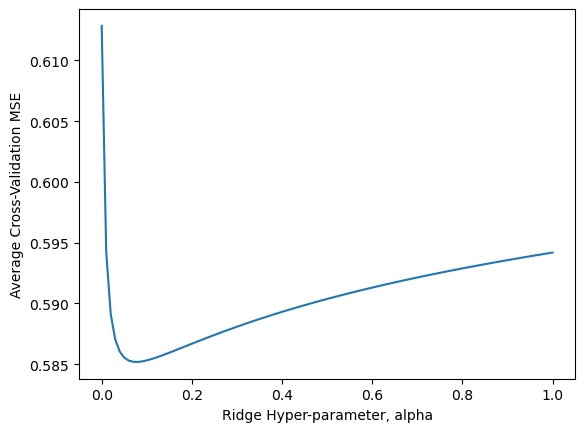

              OLS CV MSE: 0.6128392010720008
    Ridge optimal CV MSE: 0.5851882010830147
           optimal alpha: 0.08


In [1178]:
run_and_tune_Ridge(
    df_stoich45Int,
    pre_ridge_pipeline = [('poly', PolynomialFeatures(degree=2, interaction_only = True, include_bias = False))]
);

#### including all quadratic terms

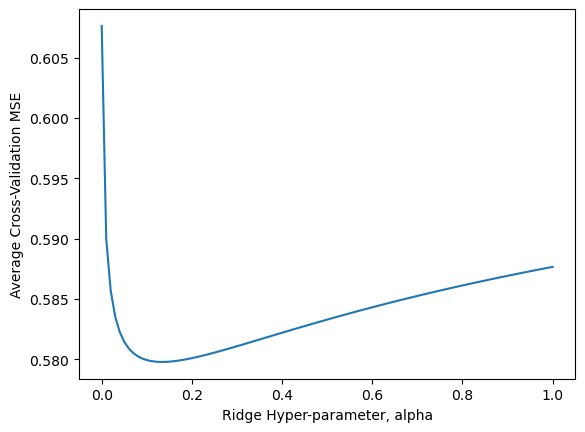

              OLS CV MSE: 0.6076433612633418
    Ridge optimal CV MSE: 0.5797816853720987
           optimal alpha: 0.13


In [1179]:
run_and_tune_Ridge(
    df_stoich45Int,
    pre_ridge_pipeline = [('poly', PolynomialFeatures(degree=2, include_bias = False))]
);

__This is the best performing so far with an average CV MSE of 0.579782__  _(improved upon below)_.
But there seems to be some over-fitting with OLS: there is a sharp drop in the CV MSE as alpha is increased from 0. Ridge regularization is helpful here.

##### Lasso
Since the above is the best performing so far, try Lasso, too.

/Users/avijka/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.674e+02, tolerance: 7.113e-01
  model = cd_fast.enet_coordinate_descent(
/Users/avijka/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.037e+02, tolerance: 7.012e-01
  model = cd_fast.enet_coordinate_descent(
/Users/avijka/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Du

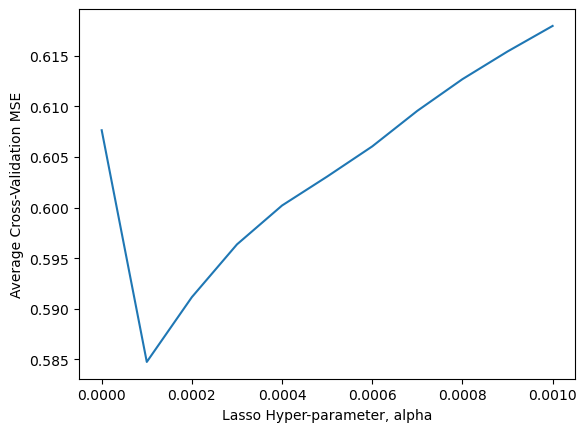

              OLS CV MSE: 0.6076433674702936
    Lasso optimal CV MSE: 0.5847463083265797
           optimal alpha: 0.0001


In [1180]:
run_and_tune_Lasso(
    df_stoich45Int,
    pre_lasso_pipeline = [('poly', PolynomialFeatures(degree=2, include_bias = False))],
    alpha_divs = 10,
    alpha_max = 0.001
);

Lasso seems to have numerical issues (and is also very slow). Below, in the "dropping from the set of polynomial features by coefficient size (*)" section, I will try a different method for dropping features.

### including all monomials up to degree 3
__Warning:__ this produces over 2000 features. Each training split has ~6000 data points. Overfitting may be a significant problem. 

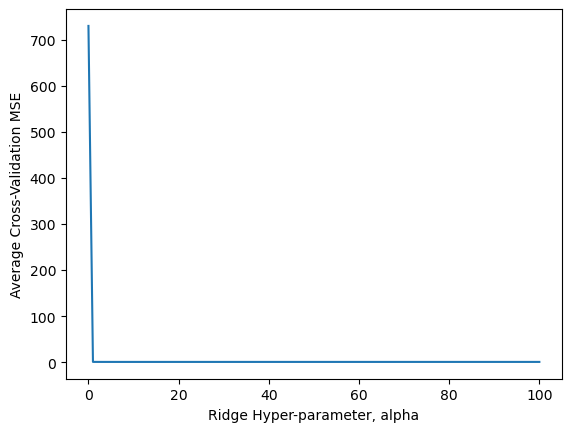

              OLS CV MSE: 730.4197762773285
    Ridge optimal CV MSE: 0.5742892268929539
           optimal alpha: 11.0


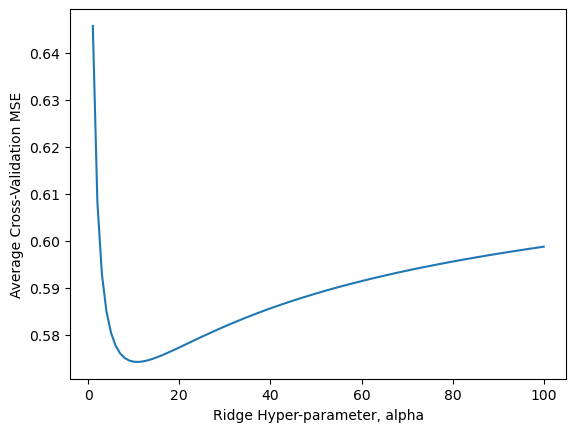

In [1181]:
_, _, mses_temp, alpha_temp = run_and_tune_Ridge(
    df_stoich45Int,
    pre_ridge_pipeline = [('poly', PolynomialFeatures(degree=3, include_bias = False))],
    alpha_divs = 100,
    alpha_max = 100.0
)
plt.plot(alpha_temp[1:],mses_temp[1:])
plt.xlabel('Ridge Hyper-parameter, alpha')
plt.ylabel('Average Cross-Validation MSE')
plt.show()

Overfitting indeed seems to be a problem. At alpha = 0 (where Ridge is equivalent to OLS), the average CV MSE is over 700! And, even with optimal Ridge regularization, including all up-to-degree-3 terms does not perform that much better than including all quadratic terms: average CV MSEs of 0.579782 vs. 0.574289. It is not reasonable to include (all) cubic terms. It might still be reasonable to include cubic terms derived from a smaller subset of features.

### including monomial terms for hand-selected features
Looking at plots of the residuals against features, it seems like the plots against melting_geometic_mean, boiling_geometric_mean, and density_geometric_mean have the most concavity. Including nonlinear terms derived from these features may have the most impact. And adding terms from _only_ these features may improve generalization.

#### including quadratic terms from hand-selected features

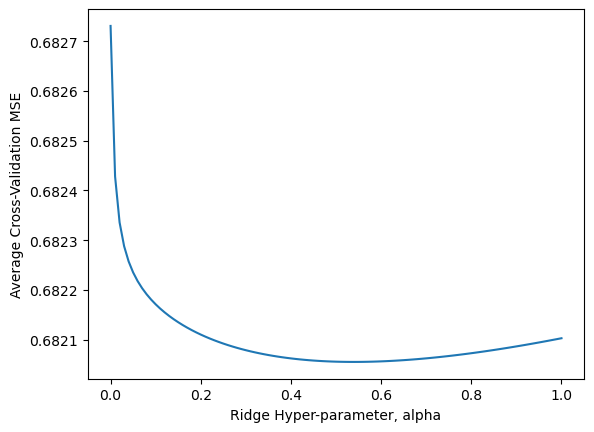

              OLS CV MSE: 0.6827306707385428
    Ridge optimal CV MSE: 0.6820555016260428
           optimal alpha: 0.54


In [1169]:
features_to_transform = ['melting_geometric_mean','boiling_geometric_mean','density_geometric_mean']

# generate just the quadratic terms from the above features
poly = PolynomialFeatures(degree = (2,2), include_bias = False)
df_poly = pd.DataFrame(poly.fit_transform(df_stoich45Int[features_to_transform]), columns = poly.get_feature_names_out())

# add back in all the original features
df_poly = df_poly.join(df_stoich45Int)

run_and_tune_Ridge(
    df_poly,
    pre_ridge_pipeline = []
);

#### including quadratic and cubic terms from hand-selected features

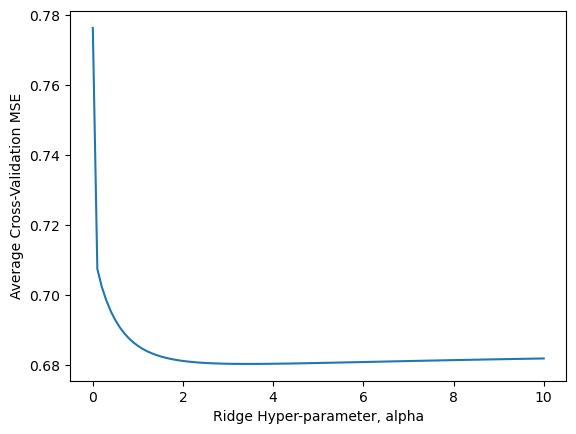

              OLS CV MSE: 0.7764310527522535
    Ridge optimal CV MSE: 0.6804269637143613
           optimal alpha: 3.4000000000000004


In [1171]:
# generate quadratic and cubic terms from the selected features
poly = PolynomialFeatures(degree = (2,3), include_bias = False)
df_poly = pd.DataFrame(poly.fit_transform(df_stoich45Int[features_to_transform]), columns = poly.get_feature_names_out())

# add back in all the original features
df_poly = df_poly.join(df_stoich45Int)

run_and_tune_Ridge(
    df_poly,
    pre_ridge_pipeline = [],
    alpha_max = 10.0
);

Adding nonlinear terms based on these select features does not come close to including all quadratic features.

### dropping from the set of polynomial features by coefficient size (*)
#### starting from all linear and quadratic features
Here I will pick up again using the full set of quadratic features, but dropping the "least important".
Since Lasso seems numerically unstable, try another method for dropping features. First, sort the features by the size of coefficients from ridge regression with the optimal alpha:

feature  coefficient
71               group_num_mean electron_affinity_mean     0.000149
23                     atomic_num_standard_deviation^2    -0.000226
255                density_mean density_geometric_mean    -0.005661
147  electron_affinity_geometric_mean electron_affi...     0.005745
288  ionization_energy_mean ionization_energy_geome...    -0.006312
..                                                 ...          ...
248             boiling_standard_deviation density_max    -2.677563
91              period_num_mean electron_affinity_mean    -2.862878
9                               melting_geometric_mean    -3.427205
21                               ionization_energy_max    -3.844475
20                ionization_energy_standard_deviation    -4.047709

[299 rows x 2 columns]

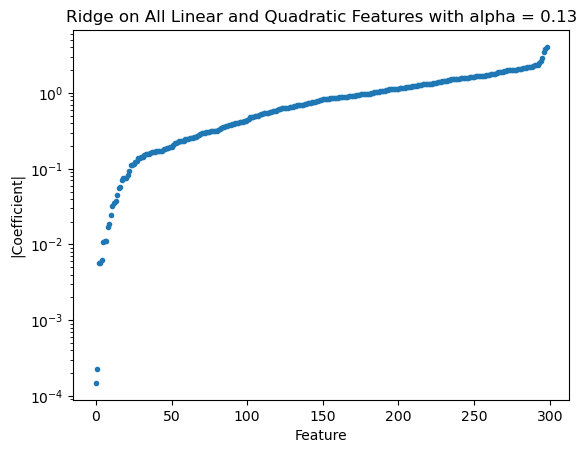

In [1256]:
model = Pipeline([('poly', PolynomialFeatures(degree=2, include_bias = False)), ('scaler', StandardScaler()), ('ridge', Ridge(alpha = 0.13))])
model.fit(X = df_stoich45Int.drop(columns = [target]), y = df_stoich45Int[target])

df_coef = pd.DataFrame()
df_coef['feature'] = model['poly'].get_feature_names_out(df_stoich45Int.columns[:-1])
df_coef['coefficient'] = model['ridge'].coef_
df_coef['|coefficient|'] = np.abs(model['ridge'].coef_)

df_coef = df_coef.sort_values(by = '|coefficient|')

plt.plot(df_coef['|coefficient|'].to_list(),'.')
plt.xlabel('Feature')
plt.ylabel('|Coefficient|')
plt.yscale('log')
plt.title('Ridge on All Linear and Quadratic Features with alpha = 0.13')
plt.plot()

df_coef[['feature', 'coefficient']]

Next, since about 25 features have very small coefficients, drop those and tune Ridge again:

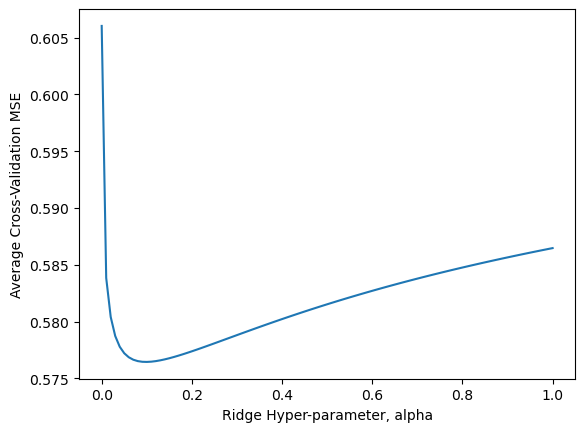

              OLS CV MSE: 0.6060233743828909
    Ridge optimal CV MSE: 0.5764584075941606
           optimal alpha: 0.1


In [1257]:
# save polynomial features to a data frame
poly = PolynomialFeatures(degree=2, include_bias = False)
df_poly = pd.DataFrame(poly.fit_transform(df_stoich45Int.drop(columns = [target])), columns = poly.get_feature_names_out())

# add target into that data frame
df_poly[target] = df_stoich45Int[target]

# drop the 25 features and run Ridge
run_and_tune_Ridge(df_poly.drop(columns = df_coef['feature'][:25]));

What about more or fewer features dropped?

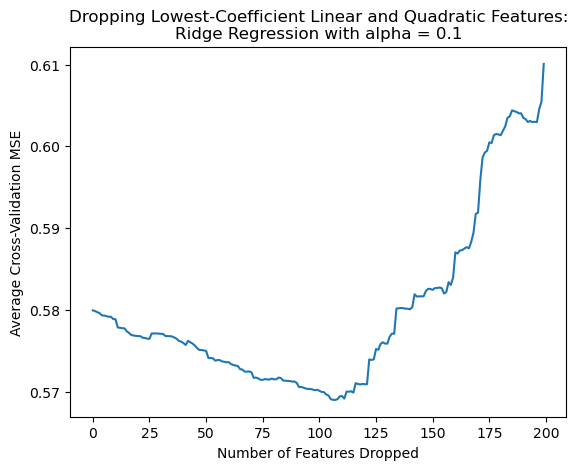

In [1258]:
# run Ridge with a fixed alpha of .1 over a range of number of features dropped:
model = Pipeline([('scale', StandardScaler()), ('ridge', Ridge(alpha = .1))])
n_drop_list = np.arange(200)
mses_temp = np.zeros(n_drop_list.shape)
for (i, n_drop) in enumerate(n_drop_list):
    mses_temp[i] = get_mean_cv_mse(model, df_poly.drop(columns = df_coef['feature'][:n_drop]))

plt.plot(n_drop_list, mses_temp)
plt.xlabel('Number of Features Dropped')
plt.ylabel('Average Cross-Validation MSE')
plt.title('Dropping Lowest-Coefficient Linear and Quadratic Features:\nRidge Regression with alpha = 0.1')
plt.show()

There is continued improvement in the cross-validation performance (for Ridge with alpha = 0.1) by dropping more and more features, with dropping around 100 being optimal. Now tune alpha for 100 dropped features:

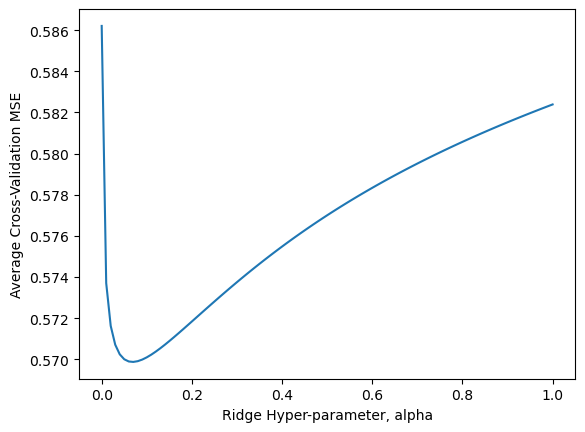

              OLS CV MSE: 0.5862068305325601
    Ridge optimal CV MSE: 0.5698718309544268
           optimal alpha: 0.07


In [1259]:
run_and_tune_Ridge(df_poly.drop(columns = df_coef['feature'][:100]));

This squeezes out a litte more performance.  __Best average CV MSE for linear regression so far: 0.569872.__ _(improved upon below)_

#### starting from all linear, quadratic, and cubic features
repeat the above analysis starting with cubic features, too

feature  coefficient
11                                         boiling_mean    -0.000002
1422  electronegativity_min density_mean ionization_...     0.000007
1988  melting_mean boiling_standard_deviation densit...    -0.000059
1599  electron_affinity_mean density_geometric_mean ...    -0.000082
1052  group_num_mean ionization_energy_geometric_mea...    -0.000089
...                                                 ...          ...
287        ionization_energy_mean ionization_energy_max    -0.294284
422   atomic_num_standard_deviation electron_affinit...     0.301780
1056             group_num_mean ionization_energy_max^2     0.325123
2595                            ionization_energy_max^3     0.406820
21                                ionization_energy_max    -0.444789

[2599 rows x 2 columns]

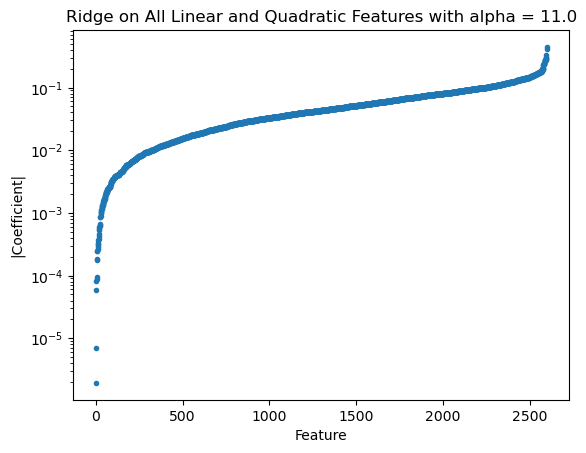

In [1261]:
model = Pipeline([('poly', PolynomialFeatures(degree=3, include_bias = False)), ('scaler', StandardScaler()), ('ridge', Ridge(alpha = 11))])
model.fit(X = df_stoich45Int.drop(columns = [target]), y = df_stoich45Int[target])

df_coef = pd.DataFrame()
df_coef['feature'] = model['poly'].get_feature_names_out(df_stoich45Int.columns[:-1])
df_coef['coefficient'] = model['ridge'].coef_
df_coef['|coefficient|'] = np.abs(model['ridge'].coef_)

df_coef = df_coef.sort_values(by = '|coefficient|')

plt.plot(df_coef['|coefficient|'].to_list(),'.')
plt.xlabel('Feature')
plt.ylabel('|Coefficient|')
plt.yscale('log')
plt.title('Ridge on All Linear and Quadratic Features with alpha = 11.0')
plt.plot()

df_coef[['feature', 'coefficient']]

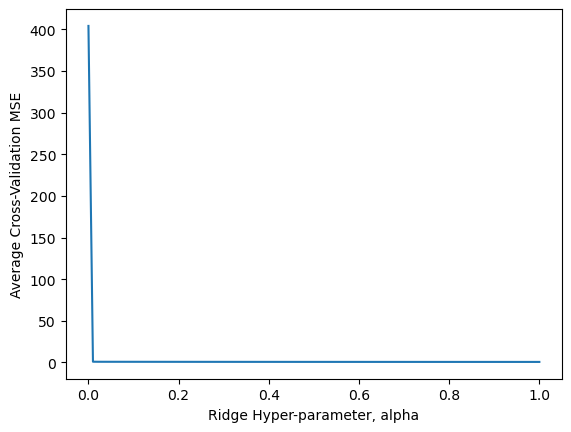

              OLS CV MSE: 404.0962748239067
    Ridge optimal CV MSE: 0.6409281898741453
           optimal alpha: 1.0


In [1262]:
# save polynomial features to a data frame
poly = PolynomialFeatures(degree=3, include_bias = False)
df_poly = pd.DataFrame(poly.fit_transform(df_stoich45Int.drop(columns = [target])), columns = poly.get_feature_names_out())

# add target into that data frame
df_poly[target] = df_stoich45Int[target]

# drop 250 features and run Ridge
run_and_tune_Ridge(df_poly.drop(columns = df_coef['feature'][:250]));

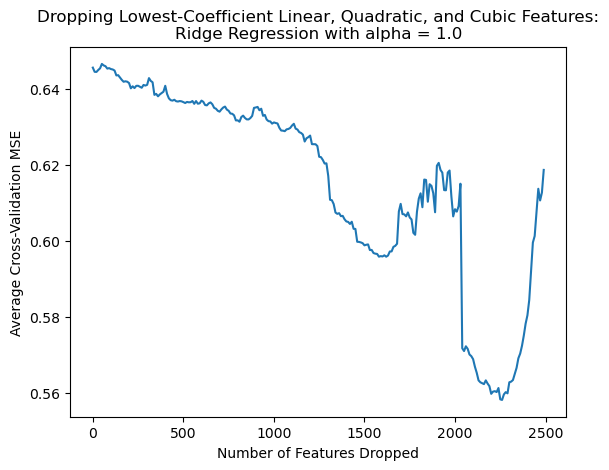

In [1266]:
# run Ridge with a fixed alpha of 1 over a range of number of features dropped:
model = Pipeline([('scale', StandardScaler()), ('ridge', Ridge(alpha = 1.0))])
n_drop_list = np.arange(0,2500,10)
mses_temp = np.zeros(n_drop_list.shape)
for (i, n_drop) in enumerate(n_drop_list):
    mses_temp[i] = get_mean_cv_mse(model, df_poly.drop(columns = df_coef['feature'][:n_drop]))

plt.plot(n_drop_list, mses_temp)
plt.xlabel('Number of Features Dropped')
plt.ylabel('Average Cross-Validation MSE')
plt.title('Dropping Lowest-Coefficient Linear, Quadratic, and Cubic Features:\nRidge Regression with alpha = 1.0')
plt.show()

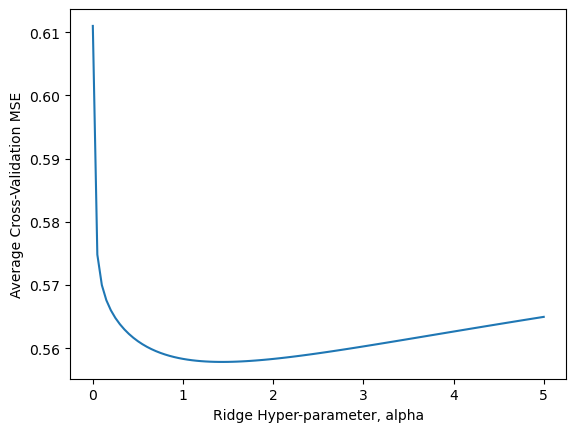

              OLS CV MSE: 0.6109949023533043
    Ridge optimal CV MSE: 0.5578282440002694
           optimal alpha: 1.45


In [1269]:
# drop 2250 features and re-run Ridge
run_and_tune_Ridge(
    df_poly.drop(columns = df_coef['feature'][:2250]),
    alpha_max = 5.0
);

This is the __best Linear Regression model so far: average CV MSE of 0.557828__

In [1272]:
model = model = Pipeline( [('scaler', StandardScaler()), ('ridge', Ridge(alpha=1.45))])
get_mean_cv_mse_and_frac_error(model, df_poly.drop(columns = df_coef['feature'][:2250]))

(0.5578282440002694, 0.19416718037833233)

### TODO: sequential thresholded least-squares
Since building a large polynomial feature set and then dropping some of the resulting features seems to be effective in improving cross-validation performance, I will try another systematic method to do so.

As described in the supplement of Brunton, Proctor, and Kutz's SINDy paper (https://www.pnas.org/doi/10.1073/pnas.1517384113), sequential thresholded least-squares is meant to be an alternative to Lasso for regularization and feature sparisification. This method runs linear regression, drops features which have fitted coefficients with magnitude below a fixed threshold, and runs linear regression again on the remaining features. It iterates the process until a final, reduced feature set is produced, where all coefficients are larger than the threshold. The threshold is a regulariztion / sparsification hyper-parameter, which can be tuned by cross-validation.

Instead of using OLS as was done in SINDy, I will generalize the method by using Ridge on each iteration. So there will be two hyper-parameters: alpha and the threshold.